<h2 style="text-align:center"> 366 Days of Porridge</h2>
<h3 style="text-align:center"> onlyporridge Analysis:</h3>

In this notebook we will take a look at a [2016 Imgur phenomenon: 366 days (Leap Year) of porridge](http://imgur.com/user/onlyporridge/submitted).  A single Imgur user, onlyporridge, posted a different picture of porridge every day in 2016.  

I have seen these posts throughout the year and usually I just laugh and move on, but this week I looked a little deeper.  I went on onlyporridge's account and saw that even though everyday the image was essentially the same, the upvotes/views varied greatly for each post.  *~lightbulb~*

---

<div>
    <img src="http://i.imgur.com/SdoGYyR.jpg" width=300/>
</div>

--- 

By analyzing how essentially the same pictured performed throughout the year, maybe we can learn more about the Imgur community as a whole and how they view/score content.  This notebook includes the following sections:

- <a href="#dependencies">Dependencies - Environment Set up</a>
- <a href="#api">Connecting to Imgur API - Data Collection</a>
- <a href="#dataprep">Use Pandas to clean the data - Data Preparation</a>
- <a href="#dataexplore">Use Seaborn and Plotly to visualize the data - Data Exploration</a>
- <a href="#classification">Use Sklearn to build a model predicting popular of images - ML Classification</a>
- <a href="#conclusion">Conclusion</a>



<div id="dependencies"><br></div>

### Dependencies - Environment Set up

In [1]:
#!pip install imgurpython --user --upgrade

In [1]:
from imgurpython import ImgurClient
import urllib
import requests
import pandas as pd
import datetime
import warnings #some of the imports trigged lots of warnings this will stop them
import pprint
pp = pprint.PrettyPrinter(indent=5) #for printing dicts

<div id="api"><br></div>

### Connecting to Imgur API - Data Collection

In [2]:
# The code was removed by DSX for sharing.

In [3]:
#list of my credentials from text file, last char is a line break so I slice it
api_cred = auth.readlines()

In [4]:
client_id = api_cred[0][:-1]
client_secret = api_cred[1][:-1]
client = ImgurClient(client_id, client_secret)

In [5]:
def get_all_user_posts(client, user_name):
    '''Uses ImgurClient and a Imgur user name to loop API calls to save their posts into a list,
    Returns list of lists, each is the contents of 1 page of user posts.  Each item in sublist is a GalleryImage object '''
    i = 0
    acc_posts = []
    while True:
        results = client.get_account_submissions(user_name, page=i)
        if results:
            acc_posts.append(results)
            i +=1
        else:
            break
    return(acc_posts)

In [6]:
user_name = 'onlyporridge'
porridge_acc = get_all_user_posts(client, user_name)

## List comprehension vs. For loops

#### List Comprehension

In [7]:
all_posts = [item for sublist in porridge_acc for item in sublist]

In [8]:
print len(all_posts)
print all_posts[1]

430


#### For Loops

In [9]:
main_list = []
for page in porridge_acc:
    for post in page:
        main_list.append(post)

In [10]:
print len(main_list)
print main_list[1]

430


#### More comprehensions

In [11]:
img_list = [i for i in all_posts if i.link[-3:] in ['png','jpg']]
len(img_list)

429

In [12]:
# Just seeing why it's 1 off.  Just random post that's not image. skip it
list(set(all_posts) - set(img_list))[0].link

u'http://imgur.com/a/KpwI7'

### Getting all the post attributes

Each post has meta data along with it, so I grab all the meta data here using `__dict__` after each object.  I'm using list comprehension to get a list of eall the dictionaries.  Think of each dictionary as a row in our table, I'll be converting to that next.

In [13]:
dict_list = [i.__dict__ for i in all_posts]

#### What the `GalleryImage` object looks like

In [14]:
pp.pprint(dict_list[0])

{    'account_id': 28839401,
     'account_url': u'onlyporridge',
     'animated': False,
     'bandwidth': 18590495976,
     'comment_count': 33,
     'datetime': 1488741947,
     'description': None,
     'downs': 74,
     'favorite': False,
     'height': 2448,
     'id': u'x1fmeMB',
     'in_gallery': True,
     'is_ad': False,
     'is_album': False,
     'link': u'http://i.imgur.com/x1fmeMB.jpg',
     'nsfw': False,
     'points': 168,
     'score': 172,
     'section': u'',
     'size': 2259144,
     'tags': [],
     'title': u'porridge',
     'topic': u'No Topic',
     'topic_id': 29,
     'type': u'image/jpeg',
     'ups': 242,
     'views': 8229,
     'vote': None,
     'width': 3264}




<div id="dataprep"><br></div>

### Use Pandas to clean the data - Data Preparation

Taking our list of dictionaries it's very easy to convert to a Pandas dataframe which will make it very easy to work with our data.

In [15]:
df = pd.DataFrame(dict_list)
df.head()

,account_id,account_url,animated,bandwidth,comment_count,cover,cover_height,cover_width,datetime,description,...,size,tags,title,topic,topic_id,type,ups,views,vote,width
0,28839401,onlyporridge,False,1.859050e+10,33,NaN,NaN,NaN,1488741947,None,...,2259144.0,[],porridge,No Topic,29,image/jpeg,242,8229,None,3264.0
1,28839401,onlyporridge,False,3.159234e+09,16,NaN,NaN,NaN,1488621830,None,...,1758060.0,[],porridge,No Topic,29,image/jpeg,82,1797,None,3264.0
2,28839401,onlyporridge,False,1.920691e+10,47,NaN,NaN,NaN,1488581504,None,...,2266570.0,[],porridge,No Topic,29,image/jpeg,252,8474,None,3264.0
3,28839401,onlyporridge,False,2.294622e+09,21,NaN,NaN,NaN,1488495785,None,...,2303837.0,[],porridge,No Topic,29,image/jpeg,53,996,None,3264.0
4,28839401,onlyporridge,False,1.724753e+10,39,NaN,NaN,NaN,1488396379,None,...,2318217.0,[],porridge,No Topic,29,image/jpeg,227,7440,None,3264.0


In [16]:
df.shape # rows, cols

(430, 35)

In [17]:
df.columns.values #column titles

array(['account_id', 'account_url', 'animated', 'bandwidth',
       'comment_count', 'cover', 'cover_height', 'cover_width', 'datetime',
       'description', 'downs', 'favorite', 'height', 'id', 'images_count',
       'in_gallery', 'is_ad', 'is_album', 'layout', 'link', 'nsfw',
       'points', 'privacy', 'score', 'section', 'size', 'tags', 'title',
       'topic', 'topic_id', 'type', 'ups', 'views', 'vote', 'width'], dtype=object)

In [18]:
keep_cols = ['link','comment_count',  'datetime', 'downs', 'points', 'score' , 'ups', 'views']

In [19]:
df_keep = df[keep_cols] #filter the full data frame for the columns we care about

In [20]:
df_keep.head()

,link,comment_count,datetime,downs,points,score,ups,views
0,http://i.imgur.com/x1fmeMB.jpg,33,1488741947,74,168,172,242,8229
1,http://i.imgur.com/drsXYqU.jpg,16,1488621830,29,53,53,82,1797
2,http://i.imgur.com/wUPqGSH.jpg,47,1488581504,69,183,187,252,8474
3,http://i.imgur.com/cqgE3u6.jpg,21,1488495785,17,36,36,53,996
4,http://i.imgur.com/sZyANyk.jpg,39,1488396379,60,167,170,227,7440


### Example timestamp conversion, mapping this on column:

In [21]:
your_timestamp = 1482880550
date = datetime.datetime.fromtimestamp(your_timestamp)
date

datetime.datetime(2016, 12, 27, 17, 15, 50)

In [22]:
jan_1_2017 =  1483228800
df_2016 = df_keep[df_keep['datetime'] < jan_1_2017] #Used for analysis and model training
df_2017 = df_keep[df_keep['datetime'] >= jan_1_2017] #Used as model testing set (for fun)

In [23]:
df_2016.shape #leap year

(366, 8)

### Mapping functions on a column of a dataframe

Here I `map` a function across the series `datetime` which is a column in the `df_2016` dataframe.   The lambda function in the map passes x (the value in the datetime column) to a conversion using fromtimestamp in the datetime module.

This is a common pattern in pandas dataframes when you need to do a column-wise computation.  We can also replace the lambda function with a pre-defined user function that can do something much more complex if needed.  Here we are mapping a function on a Series, but pandas also offes the Apply function that can be used to apply functions where an entire row or column is passed to the "map" function.

In [25]:
df_2016.loc[:,'fulldate'] = df_2016.loc[:,'datetime'].map(lambda x: datetime.datetime.fromtimestamp(x))

In [26]:
#manual label encoding
numToWeekDay = {0: 'Monday',
                1: 'Tuesday',
                2: 'Wednesday',
                3: 'Thursday',
                4: 'Friday',
                5: 'Saturday',
                6: 'Sunday'}

In [27]:
df_2016.loc[:,'dayofweek'] = df_2016.loc[:,'fulldate'].map(lambda x: numToWeekDay[x.weekday()])

In [28]:
df_2016.head()

,link,comment_count,datetime,downs,points,score,ups,views,fulldate,dayofweek
64,http://i.imgur.com/85sdOiN.jpg,265,1483203133,1199,7280,7280,8479,1217,2016-12-31 10:52:13,Saturday
65,http://i.imgur.com/UIsY0yj.jpg,90,1483122590,560,1613,1613,2173,686,2016-12-30 12:29:50,Friday
66,http://i.imgur.com/1YEGOke.jpg,104,1483054283,495,1456,1456,1951,727,2016-12-29 17:31:23,Thursday
67,http://i.imgur.com/8DKgM5r.jpg,201,1482944181,827,3383,3383,4210,516,2016-12-28 10:56:21,Wednesday
68,http://i.imgur.com/SdoGYyR.jpg,134,1482880550,571,2821,2821,3392,738,2016-12-27 17:15:50,Tuesday


### Let's take a look at the data -


<div id="dataexplore"><br></div>

### Use Seaborn and Plotly to visualize the data - Data Exploration

In [29]:
#!pip install ggplot
#!pip install plotly --user --upgrade
#! pip install cufflinks --upgrade
#!pip install seaborn --upgrade --user

In [30]:
#!pip install matplotlib==1.5.0

In [31]:
import seaborn as sns
from ggplot import *
import matplotlib.pyplot as plt
%matplotlib inline

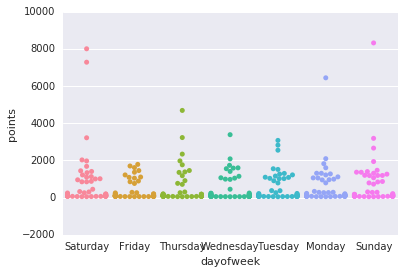

In [32]:
sns.swarmplot(x="dayofweek", y="points", data=df_2016)

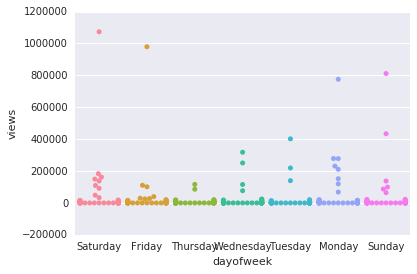

In [33]:
sns.swarmplot(x="dayofweek", y="views", data=df_2016)

In [34]:
grouped = df_2016.groupby('dayofweek').sum()
grouped['daysofweek2'] = grouped.index
grouped.sort_values('views',ascending = False, inplace=True)

In [35]:
grouped

,comment_count,datetime,downs,points,score,ups,views,daysofweek2
dayofweek,,,,,,,,
Monday,2010,76302152047,7779,28793,29938,36572,2291572,Monday
Saturday,2519,77775618881,9862,42091,43180,51953,2126415,Saturday
Sunday,2397,77764395367,9411,37305,38336,46716,1815859,Sunday
Friday,1494,77771679709,5644,19310,20010,24954,1464685,Friday
Wednesday,1715,76310929627,6970,23094,23584,30064,959170,Wednesday
Tuesday,2001,76306434283,8089,27705,28156,35794,878003,Tuesday
Thursday,1833,74853102119,5978,26101,26290,32079,382463,Thursday


In [36]:
sns.set(style="darkgrid")
def barplot_by_day(data, cols,rows=1,plot_cols=3):
    fig, axs = plt.subplots(rows,plot_cols, figsize=(7 * plot_cols ,8))  # plots on same row
    for i, col in enumerate(cols):       
        sns.barplot(x=col,y='daysofweek2',data=data, palette="muted", ax= axs[i])
        axs[i].set_title(col.title()+' by Day of Week')
        axs[i].set(ylabel='Days of Week', xlabel='Mean '+ col.title())

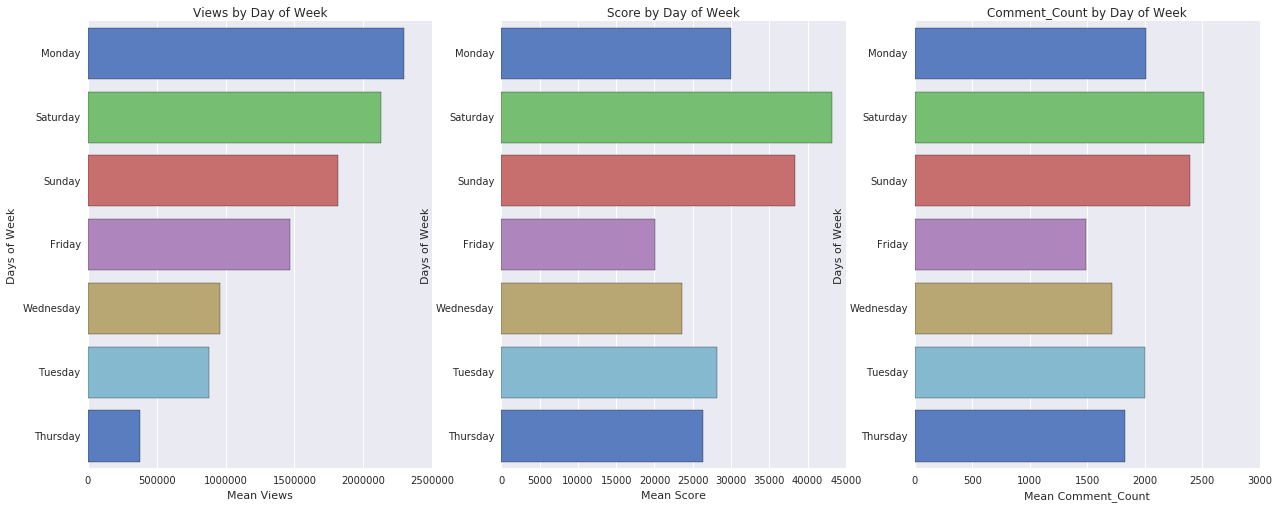

In [37]:
barplot_by_day(grouped, ['views','score','comment_count'],1,3)

In [38]:
def single_barplot_by_day(data, col):
    ax = sns.barplot(x="daysofweek2", y=col, data=data)
    ax.set(xlabel='Days of Week', ylabel='Mean '+col.title())
    ax.set_title(col.title() + ' By Day of Week')
    


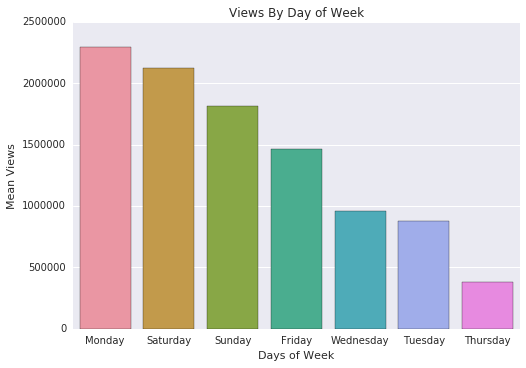

In [39]:
single_barplot_by_day(grouped,'views')

### Cool to see counts by day, but let's look at time series over 2016

#### First we need to make our dataframe a timeseries indexed dataframe


In [40]:
time_df = df_2016.set_index(df_2016['fulldate'])

In [41]:
time_df.sort_index(inplace=True)
time_df.head(2) #start from beginning of 2016

,link,comment_count,datetime,downs,points,score,ups,views,fulldate,dayofweek
fulldate,,,,,,,,,,
2016-01-01 01:03:29,http://i.imgur.com/08J7OY7.jpg,109,1451631809,39,1219,1238,1258,39586,2016-01-01 01:03:29,Friday
2016-01-02 07:44:24,http://i.imgur.com/rCA0mqm.jpg,15,1451742264,36,325,341,361,33028,2016-01-02 07:44:24,Saturday


#### Now the data is in the right shape, let's take a look 

In [42]:
import plotly.plotly as py
import plotly.graph_objs as go
import cufflinks as cf

#### Plotly credentials - get these from your Plotly account.  I have mine in the auth.cfg file:  `py.sign_in(username,key)`

In [43]:
py.sign_in(api_cred[2][:-1], api_cred[3][:-1])

In [44]:
data = [go.Scatter(
          x= time_df.index,
          y=time_df['score'].values.tolist())]

In [45]:
py.iplot(data)

In [47]:
py.iplot([{
    'x': time_df.index,
    'y': time_df[col],
    'name': col
}  for col in df.columns if col in ['score','views','comment_count']])

### Data processing for ML

In [48]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

In [49]:
ml_df = time_df.drop(['link','datetime','dayofweek'],axis=1)
ml_df.head(2)

,comment_count,downs,points,score,ups,views,fulldate
fulldate,,,,,,,
2016-01-01 01:03:29,109,39,1219,1238,1258,39586,2016-01-01 01:03:29
2016-01-02 07:44:24,15,36,325,341,361,33028,2016-01-02 07:44:24


In [50]:
ml_df['hour'] = ml_df.fulldate.map(lambda x: x.hour)
ml_df['minute'] = ml_df.fulldate.map(lambda x: x.minute)
ml_df['day_num'] = ml_df.fulldate.map(lambda x: x.day)
ml_df['month'] = ml_df.fulldate.map(lambda x: x.month)
ml_df['day_week'] = ml_df.fulldate.map(lambda x: x.weekday())
ml_df.drop('fulldate',axis=1,inplace=True)


In [51]:
ml_df.shape

(366, 11)

In [52]:
###### ml_df.apply(lambda row: print row, axis= 1)

In [53]:
day_hour_group = ml_df.groupby([ml_df.day_week, ml_df.hour]).mean()

In [54]:
heatmap_df = np.zeros((24,7))

In [55]:
ml_df.head(1)

,comment_count,downs,points,score,ups,views,hour,minute,day_num,month,day_week
fulldate,,,,,,,,,,,
2016-01-01 01:03:29,109,39,1219,1238,1258,39586,1,3,1,1,4


In [56]:
def set_matrix_vals(arr,hour,day,score):    
    arr[hour,day] += score

In [57]:
pd.unique(ml_df['hour'])

array([ 1,  7, 14, 11, 10, 12,  5, 15, 13, 16,  8, 17,  2,  9,  6,  4,  3,
       18, 20, 19,  0])

In [58]:
ml_df.apply(lambda row: set_matrix_vals(heatmap_df,row[6],row[10],row[3]),axis=1)
print ''

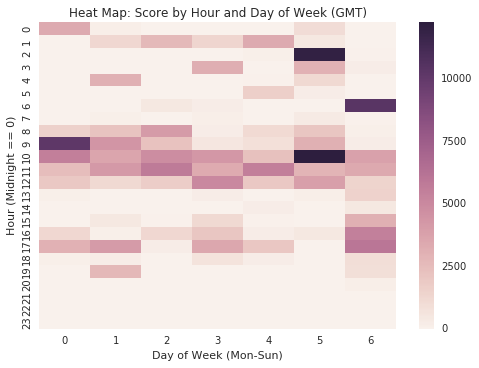

In [59]:
ax = plt.axes()
sns.heatmap(heatmap_df, ax = ax)

ax.set(xlabel='Day of Week (Mon-Sun)', ylabel='Hour (Midnight == 0)')
ax.set_title('Heat Map: Score by Hour and Day of Week (GMT)')
plt.show()

In [60]:
avg_score = ml_df.score.median()
ml_df['target'] = 0
ml_df.loc[ml_df.score > avg_score, 'target'] = 1

In [61]:
ml_df.target.value_counts(sort=True)

1    183
0    183
Name: target, dtype: int64

In [62]:
ml_df.head(5)

,comment_count,downs,points,score,ups,views,hour,minute,day_num,month,day_week,target
fulldate,,,,,,,,,,,,
2016-01-01 01:03:29,109,39,1219,1238,1258,39586,1,3,1,1,4,1
2016-01-02 07:44:24,15,36,325,341,361,33028,7,44,2,1,5,1
2016-01-03 14:53:35,8,27,287,287,314,224,14,53,3,1,6,1
2016-01-04 11:20:44,11,28,267,267,295,182,11,20,4,1,0,1
2016-01-05 10:47:02,9,39,217,217,256,169,10,47,5,1,1,1


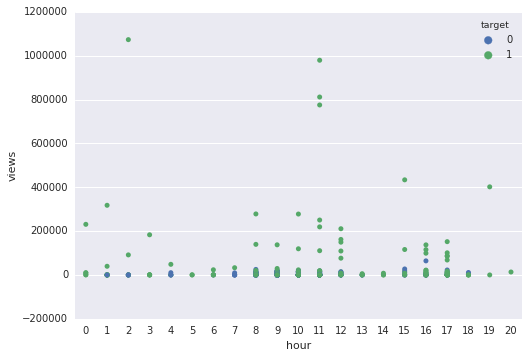

In [63]:
sns.stripplot(x="hour", y="views",hue='target', data = ml_df)

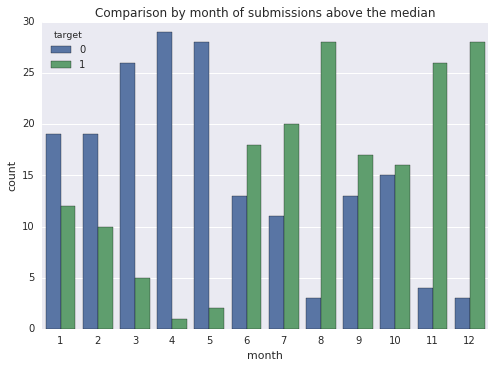

In [64]:
ax = sns.countplot(x="month", hue="target",data=ml_df)
ax.set_title('Comparison by month of submissions above the median')

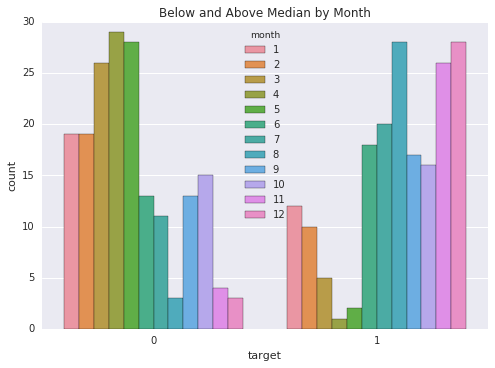

In [65]:
ax = sns.countplot(x="target", hue="month",data=ml_df)
ax.set_title('Below and Above Median by Month')
plt.show()

In [66]:
def draw_facet_grid(df,compare_col,class_label):
    g = sns.FacetGrid(df, col=class_label)
    g.map(plt.hist, compare_col)
    g.set

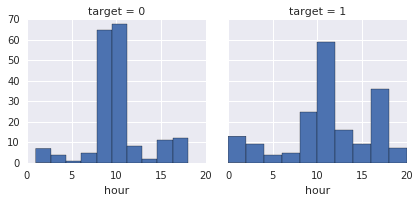

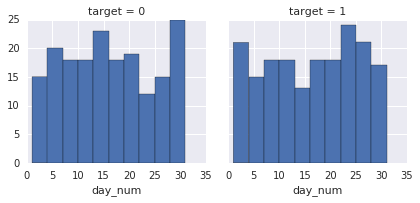

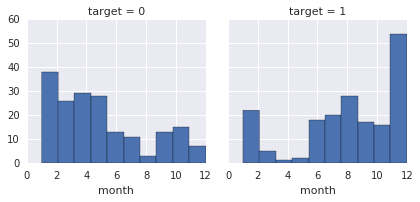

In [67]:
draw_cols= ['hour','day_num','month']
for col in draw_cols:
    draw_facet_grid(ml_df,col,'target')

In [68]:
cors = ml_df.corr()
s = cors.unstack()
so = s.sort_values(kind="quicksort",ascending=False)
highly_corr = so[(so >= 0.7) & (so < 1)]

In [69]:
highly_corr[:10]

points         score            0.998850
score          points           0.998850
ups            points           0.995903
points         ups              0.995903
score          ups              0.995020
ups            score            0.995020
comment_count  ups              0.945112
ups            comment_count    0.945112
comment_count  score            0.927507
score          comment_count    0.927507
dtype: float64

In [70]:
ml_reduced = ml_df.drop(['points','score','ups','downs','comment_count','views'],axis=1)
cors = ml_reduced.corr()
s = cors.unstack()
so = s.sort_values(kind="quicksort",ascending=False)
highly_corr = so[(so >= 0.7) & (so < 1)]

In [71]:
highly_corr

Series([], dtype: float64)

In [72]:
ml_dum = pd.get_dummies(ml_reduced,columns=['hour','minute','day_num','month'])
cors = ml_dum.corr()
s = cors.unstack()
so = s.sort_values(kind="quicksort",ascending=False)
highly_corr = so[(so >= 0.7) & (so < 1)]

In [73]:
highly_corr

Series([], dtype: float64)

In [74]:
ml_dum.head(2)


,day_week,target,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
fulldate,,,,,,,,,,,,,,,,,,,,,
2016-01-01 01:03:29,4,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-01-02 07:44:24,5,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


<div id="classification"><br></div>

### Simple classification with Sci-kit Learn



In [75]:
def move_to_end(df,col_name):
    '''Accepts Pandas Dataframe and column name and moves that column to the end.  Intended to be used for the target variable before converting to numpy array'''
    cols_arranged = df.columns.values.tolist()
    cols_arranged.remove(col_name)
    cols_arranged.append(col_name)
    df = df[cols_arranged]
    return(df)

In [76]:
ml_dum = move_to_end(ml_dum,'target')

In [77]:
ml_dum.columns

Index([u'day_week', u'hour_0', u'hour_1', u'hour_2', u'hour_3', u'hour_4',
       u'hour_5', u'hour_6', u'hour_7', u'hour_8',
       ...
       u'month_4', u'month_5', u'month_6', u'month_7', u'month_8', u'month_9',
       u'month_10', u'month_11', u'month_12', u'target'],
      dtype='object', length=126)

In [78]:
x = ml_dum.ix[:,:-1].values # scale every thing except last column
standard_scaler = StandardScaler()
x_std = standard_scaler.fit_transform(x)

/usr/local/src/bluemix_jupyter_bundle.v35/notebook/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.

/usr/local/src/bluemix_jupyter_bundle.v35/notebook/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning:

Data with input dtype int64 was converted to float64 by StandardScaler.



In [79]:
y = ml_df.ix[:,-1].values
# encode the class label
# class_labels = np.unique(y)
# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y)


In [80]:
test_percentage = 0.1
x_train, x_test, y_train, y_test = train_test_split(x_std, y, test_size = test_percentage, random_state = 0)


In [81]:
from sklearn import tree

In [82]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)

In [83]:
preds = clf.predict(x_test)

In [84]:
from sklearn import metrics
print(metrics.classification_report(y_test, preds,target_names=['Below Median','Above Median']))

              precision    recall  f1-score   support

Below Median       0.75      0.82      0.78        22
Above Median       0.69      0.60      0.64        15

 avg / total       0.73      0.73      0.73        37



<div id="conclusion"><br></div>


### Conclusion

People like porridge.  


Future work - build pipeline for scoring new images everyday based on the model. 